In [1]:
import os
import sys
import numpy as np
import datetime
import matplotlib.pyplot as plt
# from scipy.misc import *
from skimage.transform import resize as imresize
import imageio
from glob import glob

from __future__ import print_function, division
from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
#         self.img_shape = (self.channels, self.img_rows, self.img_cols)

        # Configure data loader
        self.dataset_name = 'train'
        
        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 4
        self.df = 4

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()
        
        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)


In [3]:
if __name__ == '__main__':
    gan = Pix2Pix()
#     gan.generator.summary()
#     gan.discriminator.summary()
#     gan.combined.summary()

In [4]:
    def generator_training_Img(real_list_dir,white_list_dir,resize=None,batch_size=32):
        batch_real_img=[]
        batch_white_img=[]
        for _ in range(batch_size):
            random_img_index = np.random.randint(0, 100, size=100)[0]
            real_img =  imageio.imread(real_list_dir[random_img_index] ,pilmode='L')
            white_img =  imageio.imread(white_list_dir[random_img_index] ,pilmode='L')

            if resize:
                real_img = imresize(real_img,resize, mode='constant')
                white_img = imresize(white_img,resize, mode='constant')
            batch_real_img.append(real_img)
            batch_white_img.append(white_img)
        batch_real_img = np.array(batch_real_img)/127.5-1
        batch_real_img = np.expand_dims(batch_real_img,axis=1)
        batch_white_img = np.array(batch_white_img)/127.5-1
        batch_white_img = np.expand_dims(batch_white_img,axis=3)
        return batch_real_img,batch_white_img

In [5]:
    train_real_data_dir = r'./datasets/train/Real/*'
    train_white_data_dir = r'./datasets/train/White/*'

    real_list = glob(train_real_data_dir)
    train_real_data_list = []
    train_real_data_list.extend(real_list)

    white_list = glob(train_white_data_dir)
    train_white_data_list = []
    train_white_data_list.extend(white_list)
    
    ori_img,white_img = generator_training_Img(real_list_dir=train_real_data_list,
                                               white_list_dir=train_white_data_list,
                                               resize=(128,128),
                                               batch_size=100)
    print(ori_img.shape, white_img.shape)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(100, 1, 128, 128) (100, 128, 128, 1)


In [6]:
    epochs = 4
    batch_size = 1
    all_d_loss = np.zeros(epochs)
    all_g_loss = np.zeros(epochs)
    start_time = datetime.datetime.now()
        
    # Adversarial loss ground truths
    valid = np.ones((batch_size,) + gan.disc_patch)
    fake = np.zeros((batch_size,) + gan.disc_patch)
        
    #  Train Discriminator
    
    for epoch in range(0, epochs):
            narray_imgsB = white_img
#             batch_i = 0
            for batch_i in range(len(ori_img)):
                imgs_A = ori_img[batch_i]
                imgs_B = narray_imgsB[batch_i]
#                 print(imgs_A.shape)
#                 print(imgs_A[0], imgs_B[0])
#                 plt.imshow(imgs_B.reshape((128,128)) )
#                 plt.imshow(imgs_A.reshape((128,128)) )
#                 batch_i += 1
                # Condition on B and generate a translated version
                imgs_B = imgs_B.reshape((1,128,128,1))
                imgs_A = imgs_A.reshape((1,128,128,1))
                fake_A = gan.generator.predict(imgs_B)
                
                
                # Train the discriminators (original images = real / generated = Fake)
                # imgs_B is white img
                d_loss_real = gan.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = gan.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                
                # Train the generators
                g_loss = gan.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
                    
                elapsed_time = str(datetime.datetime.now() - start_time)
            all_d_loss[epoch] = d_loss[0]
            all_g_loss[epoch] = g_loss[0]
            print_out = (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss[0],elapsed_time.split(".")[0])
            print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % print_out)
            np.savetxt("all_d_loss.txt", all_d_loss, delimiter=",")
            np.savetxt("all_g_loss.txt", all_g_loss, delimiter=",")

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/4]  [D loss: 0.114525, acc:  84%] [G loss: 111.233009] time: 0:00:14
[Epoch 1/4]  [D loss: 0.043439, acc:  93%] [G loss: 104.579552] time: 0:00:21
[Epoch 2/4]  [D loss: 0.025191, acc:  97%] [G loss: 101.581467] time: 0:00:28
[Epoch 3/4]  [D loss: 0.012361, acc: 100%] [G loss: 101.189735] time: 0:00:35


In [7]:
#     gan.train(epochs= 100, batch_size= 1)

In [8]:
    test_white_list = glob(train_white_data_dir)
    test_white_data_list = []
    test_white_data_list.extend(test_white_list)
    
    ori_img,test_white_data_list = generator_training_Img(real_list_dir=train_real_data_list,
                                               white_list_dir=test_white_data_list,
                                               resize=(128,128),
                                               batch_size=10)
    imgs_test = test_white_data_list
#     imgs_test = imgs_test[:,:,:,:1]
    fake_A = gan.generator.predict(test_white_data_list)
    gen_imgs = np.concatenate([fake_A])
#     gen_imgs = 0.5 * gen_imgs

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [9]:
    ids = 0
    for img in gen_imgs:
        img = img.reshape((128, 128))
        plt.imsave("res_images/main_test_res_" + str(ids) + ".jpg", img, cmap="gray")
        ids += 1                  
    plt.close()   
    print("test_data generator predict over.")

test_data generator predict over.


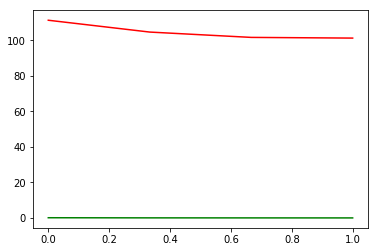

In [10]:
# draw loss 
all_d_loss_txt = np.loadtxt("all_d_loss.txt")
all_g_loss_txt = np.loadtxt("all_g_loss.txt")

# print( all_d_loss_txt.shape, all_d_loss_txt.shape[0])
# print(all_g_loss_txt, all_g_loss_txt.shape, all_g_loss_txt.shape[0])

fig = plt.figure()
ax = plt.axes()
all_d_loss_x = np.linspace(0, 1, all_d_loss_txt.shape[0])
all_g_loss_x = np.linspace(0, 1, all_g_loss_txt.shape[0])

plt.plot(all_g_loss_x, all_g_loss_txt, '-r');  # dotted red, g_loss
plt.plot(all_d_loss_x , all_d_loss_txt , '-g');  # dotted green, d_loss

plt.show()

In [11]:
#     gan.sample_images(20, 1)

In [12]:
# ss = np.array([1,2,3])
# ss[1]